Epoch 1, Loss: 0.16010595292633903
Epoch 2, Loss: 0.0074545936330170865
Epoch 3, Loss: 0.0021617035201641796
Epoch 4, Loss: 0.0009492201456941826
Epoch 5, Loss: 0.0005839883818524862
Epoch 6, Loss: 0.00041482765473224405
Epoch 7, Loss: 0.0003121768976677646
Epoch 8, Loss: 0.00023888471137236935
Epoch 9, Loss: 0.00019596922627794654
Epoch 10, Loss: 0.00016539944846417754
Epoch 11, Loss: 0.0001549791019720538
Epoch 12, Loss: 0.00011665890780568653
Epoch 13, Loss: 7.670888769982971e-05
Epoch 14, Loss: 6.635771086704416e-05
Epoch 15, Loss: 4.8894681503714515e-05
Confusion Matrix:
[[854   2]
 [  8 282]]
F1-Score: 0.9825783972125436
Accuracy: 0.9912739965095986


<ipython-input-3-3f62bb62403d>:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lstm_model.pth'))


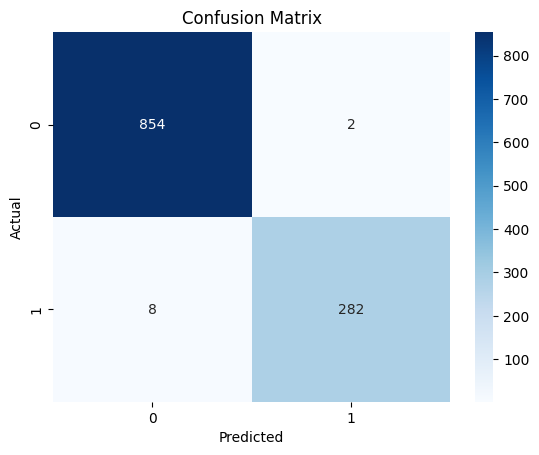

In [3]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = '/content/emails.xlsx'
data = pd.read_excel(file_path)

# Preprocess data
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['text']).toarray()  # Convert text to numeric values
y = data['spam'].values  # Target variable

# Split data into train (%80) and test (%20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Dataset class
class EmailDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # Add sequence dimension
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets and dataloaders
train_dataset = EmailDataset(X_train, y_train)
test_dataset = EmailDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Model parameters
input_size = X_train.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# Save the model
torch.save(model.state_dict(), 'lstm_model.pth')

# Load the saved model
model.load_state_dict(torch.load('lstm_model.pth'))

# Test evaluation
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        test_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
        test_labels.extend(y_batch.cpu().numpy())

# Calculate metrics
conf_matrix = confusion_matrix(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
accuracy = accuracy_score(test_labels, test_preds)

# Print results
print("Confusion Matrix:")
print(conf_matrix)
print(f"F1-Score: {f1}")
print(f"Accuracy: {accuracy}")

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()